

## ICPR 2026 - Crop Disease Classification with Prithvi Foundation Model

This notebook implements crop disease classification using the Prithvi geospatial foundation model.

**Data:** 720 labeled Sentinel-2 crop disease images (4 classes: Aphid, Blast, RPH, Rust)

**Model:** Prithvi Vision Transformer (300M/600M parameters) pretrained on NASA's HLS dataset



## 1. Setup and Installation

In [ ]:
# Install required packages

!pip install git+https://github.com/IBM/terratorch.git

  Cloning https://github.com/IBM/terratorch.git to /tmp/pip-req-build-xd02pl6l
  Running command git clone --filter=blob:none --quiet https://github.com/IBM/terratorch.git /tmp/pip-req-build-xd02pl6l
  Resolved https://github.com/IBM/terratorch.git to commit e4a7da4440c58e29e7efbde8145675c9bdeb26b6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# import libraries
import os
import sys
import numpy as np
import rasterio
from tqdm import tqdm
import pandas as pd
from pathlib import Path

import terratorch
from terratorch.tasks import ClassificationTask
from terratorch.datasets.transforms import FlattenTemporalIntoChannels, UnflattenTemporalFromChannels

import albumentations as A
from albumentations import Compose
from albumentations.pytorch import ToTensorV2

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint

import torch
from torch.utils.data import Dataset, DataLoader

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


## 2. Configuration

In [ ]:
# Mount Google Drive
from google.colab import drive


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Set paths
data_root = "/content/drive/MyDrive/ICPR/outputs/preprocessed"
output_dir = "/content/drive/MyDrive/ICPR/outputs"
test_dir = "/content/drive/MyDrive/ICPR/outputs/preprocessed"

print(f"Data root: {data_root}")
print(f"Output directory: {output_dir}\n")

Data root: /content/drive/MyDrive/ICPR/outputs/preprocessed
Output directory: /content/drive/MyDrive/ICPR/outputs



In [ ]:
# Check one preprocessed file
test_file = Path("/content/drive/MyDrive/ICPR/outputs/preprocessed/train/Aphid/6c1128f5c3884e2ebe1cc61073982d58.tif")

with rasterio.open(test_file) as src:
    print(f"File shape: {src.shape}")  # (H, W)
    print(f"Band count: {src.count}")   # Should be 6
    print(f"Bands shape: (count={src.count}, height={src.height}, width={src.width})")

    # Read data
    data = src.read()  # Reads as (bands, H, W)
    print(f"Data shape after read: {data.shape}")

File shape: (264, 264)
Band count: 6
Bands shape: (count=6, height=264, width=264)
Data shape after read: (6, 264, 264)


## 3. Custom Dataset and DataModule

The dataset loads preprocessed 6-band Sentinel-2 images (264×264 pixels) and:
1. Resizes to 224×224 (Prithvi's input size)
2. Normalizes using Prithvi's HLS statistic

In [ ]:
class ICPRDataset(Dataset):
    def __init__(self, data_root, transform=None, constant_scale=1.0, means=None, stds=None, is_test=False):
        self.data_root = Path(data_root)
        self.transform = transform
        self.constant_scale = constant_scale
        self.means = np.array(means) if means is not None else None
        self.stds = np.array(stds) if stds is not None else None

        # Collect all samples
        self.samples = []
        self.class_to_idx = {'Aphid': 0, 'Blast': 1, 'RPH': 2, 'Rust': 3}

        if is_test:
            # Test: flat folder, no labels
            for img_file in self.data_root.glob('*.tif'):
                self.samples.append((img_file, -1))

        else:

          for class_name, class_idx in self.class_to_idx.items():
            class_folder = self.data_root / class_name
            if class_folder.exists():
                for img_file in class_folder.glob('*.tif'):
                    self.samples.append((img_file, class_idx))

        print(f"Found {len(self.samples)} images in {data_root}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        # Read image correctly as (C, H, W)
        with rasterio.open(img_path) as src:
            image = src.read().astype('float32')  # (6, 264, 264)

        # Transpose to (H, W, C) for albumentations
        image = image.transpose(1, 2, 0)  # (264, 264, 6)

        # Apply transforms (resize + ToTensor)
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']  # (6, 224, 224) tensor

        # Normalize: (image - mean) / std
        if self.means is not None and self.stds is not None:
            means = torch.tensor(self.means, dtype=image.dtype).view(-1, 1, 1)  # (6, 1, 1)
            stds = torch.tensor(self.stds, dtype=image.dtype).view(-1, 1, 1)    # (6, 1, 1)
            image = (image - means) / stds

        return {
            'image': image,
            'label': torch.tensor(label, dtype=torch.long),
            'filename': img_path.stem
        }


class ICPRDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_root,
        batch_size=16,
        num_workers=4,
        img_size=224,
        constant_scale=1.0,
        means=None,
        stds=None
    ):
        super().__init__()
        self.data_root = Path(data_root)
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.img_size = img_size
        self.constant_scale = constant_scale
        self.means = means
        self.stds = stds

    def setup(self, stage=None):
        # Transforms - just resize, no augmentation
        self.train_transform = A.Compose([
            A.Resize(self.img_size, self.img_size),
            ToTensorV2(),
        ])

        self.val_transform = A.Compose([
            A.Resize(self.img_size, self.img_size),
            ToTensorV2(),
        ])

        # Create datasets
        if stage in ["fit", None]:
            self.train_dataset = ICPRDataset(
                self.data_root / "train",
                transform=self.train_transform,
                constant_scale=self.constant_scale,
                means=self.means,
                stds=self.stds
            )
            self.val_dataset = ICPRDataset(
                self.data_root / "val",
                transform=self.val_transform,
                constant_scale=self.constant_scale,
                means=self.means,
                stds=self.stds
            )

             # Add test dataset
        if stage in ["test", "predict", None]:
            self.test_dataset = ICPRDataset(
                self.data_root / "test",
                transform=self.val_transform,
                constant_scale=self.constant_scale,
                means=self.means,
                stds=self.stds,
                is_test=True
            )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )


    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

    def predict_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

#### Verify Data Loading

In [ ]:
# Prithvi normalization
PRITHVI_MEANS = [1087.0, 1342.0, 1433.0, 2734.0, 1958.0, 1363.0]
PRITHVI_STDS= [2248.0, 2179.0, 2178.0, 1850.0, 1242.0, 1049.0]

# Create datamodule
datamodule_check = ICPRDataModule(
    data_root=data_root,
    batch_size=16,
    num_workers=4,
    img_size=224,
    means=PRITHVI_MEANS,
    stds=PRITHVI_STDS
)

# Test
datamodule_check.setup(stage="fit")
train_loader = datamodule_check.train_dataloader()

batch = next(iter(train_loader))

print("=" * 60)
print("Custom DataModule with Normalization:")
print("=" * 60)
print(f" Image shape: {batch['image'].shape}")  # (16, 6, 224, 224)
print(f" Label shape: {batch['label'].shape}")  # (16,)
print(f" Image min/max: {batch['image'].min():.4f} / {batch['image'].max():.4f}")
print(f"Image mean: {batch['image'].mean():.4f}")
print(f"Label values: {batch['label'].unique()}")
print(f"\n Class mapping: {datamodule_check.train_dataset.class_to_idx}")

Found 720 images in /content/drive/MyDrive/ICPR/outputs/preprocessed/train
Found 180 images in /content/drive/MyDrive/ICPR/outputs/preprocessed/val


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Custom DataModule with Normalization:
 Image shape: torch.Size([16, 6, 224, 224])
 Label shape: torch.Size([16])
 Image min/max: -1.4019 / 7.5848
Image mean: 0.6356
Label values: tensor([0, 1, 2, 3])

 Class mapping: {'Aphid': 0, 'Blast': 1, 'RPH': 2, 'Rust': 3}


## 4. Model Configurations

In [ ]:
BATCH_SIZE = 16
EPOCHS = 100
LR = 2.0e-4
WEIGHT_DECAY = 0.1
HEAD_DROPOUT=0.1
FREEZE_BACKBONE = False

NUM_FRAMES = 1

SEED = 42

In [ ]:
# Class counts in order [Aphid, Blast, RPH, Rust]
class_counts = [232, 60, 396, 32]
total = sum(class_counts)

# Inverse frequency weighting
class_weights = [total / (len(class_counts) * count) for count in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float32)

print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

Class counts: [232, 60, 396, 32]
Class weights: tensor([0.7759, 3.0000, 0.4545, 5.6250])


## 5. Training Setup

In [ ]:
pl.seed_everything(SEED)

# Base experiment directory
experiment_name = "crop_classification"
experiment_dir = os.path.join(output_dir, experiment_name)

# Create logger
logger = TensorBoardLogger(
    save_dir=output_dir,
    name=experiment_name,
)

# Logger will create: crop_classification/version_0/ (or version_1, etc.)
# Get the version directory that logger created
version_dir = logger.log_dir  # This is crop_classification/version_X

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val/F1_Score",
    mode="max",
    dirpath=os.path.join(version_dir, "checkpoints"),
    filename="best-checkpoint-{epoch:02d}-{val_f1:.2f}",
    save_top_k=1,
)

# Optional: Early stopping (commented out as not used in final experiments)
# early_stop = EarlyStopping(
#     monitor="val/F1_Score",
#     patience=50,
#     mode="max",
#     min_delta=0.002,
#     verbose=True,
# )

# Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices="auto",
    precision="bf16-mixed",
    num_nodes=1,
    logger=logger,
    max_epochs=EPOCHS,
    enable_progress_bar=True,
    check_val_every_n_epoch=1,
    log_every_n_steps=10,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback],
)

# DataModule
datamodule = ICPRDataModule(
    data_root=data_root,
    batch_size=BATCH_SIZE,
    num_workers=4,
    img_size=224,
    means=PRITHVI_MEANS,
    stds=PRITHVI_STDS

)



INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


In [ ]:
# Model

backbone_args = dict(
    backbone_pretrained=True,
    backbone="prithvi_eo_v2_600", # prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl
    backbone_num_frames=NUM_FRAMES,
)



model_args = dict(
    **backbone_args,
    decoder="IdentityDecoder",
    num_classes=4,
    head_dropout=HEAD_DROPOUT,
    rescale=True,
)


model = ClassificationTask(
    model_args=model_args,
    plot_on_val=False,
    class_weights=class_weights,
    loss="ce",
    lr=LR,
    optimizer="AdamW",
    optimizer_hparams=dict(weight_decay=WEIGHT_DECAY),
    freeze_backbone=True,
    freeze_decoder=False,
    model_factory="EncoderDecoderFactory",
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## 6. Training

In [ ]:
# Training
trainer.fit(model, datamodule=datamodule)

Available metrics: ['hp_metric', 'train/loss', 'epoch', 'val/loss', 'val/Accuracy', 'val/Accuracy_Micro', 'val/Class_Accuracy_0', 'val/Class_Accuracy_1', 'val/Class_Accuracy_2', 'val/Class_Accuracy_3', 'val/Class_F1_0', 'val/Class_F1_1', 'val/Class_F1_2', 'val/Class_F1_3', 'val/F1_Score', 'val/Precision', 'val/Recall', 'train/Accuracy', 'train/Accuracy_Micro', 'train/Class_Accuracy_0', 'train/Class_Accuracy_1', 'train/Class_Accuracy_2', 'train/Class_Accuracy_3', 'train/Class_F1_0', 'train/Class_F1_1', 'train/Class_F1_2', 'train/Class_F1_3', 'train/F1_Score', 'train/Precision', 'train/Recall']


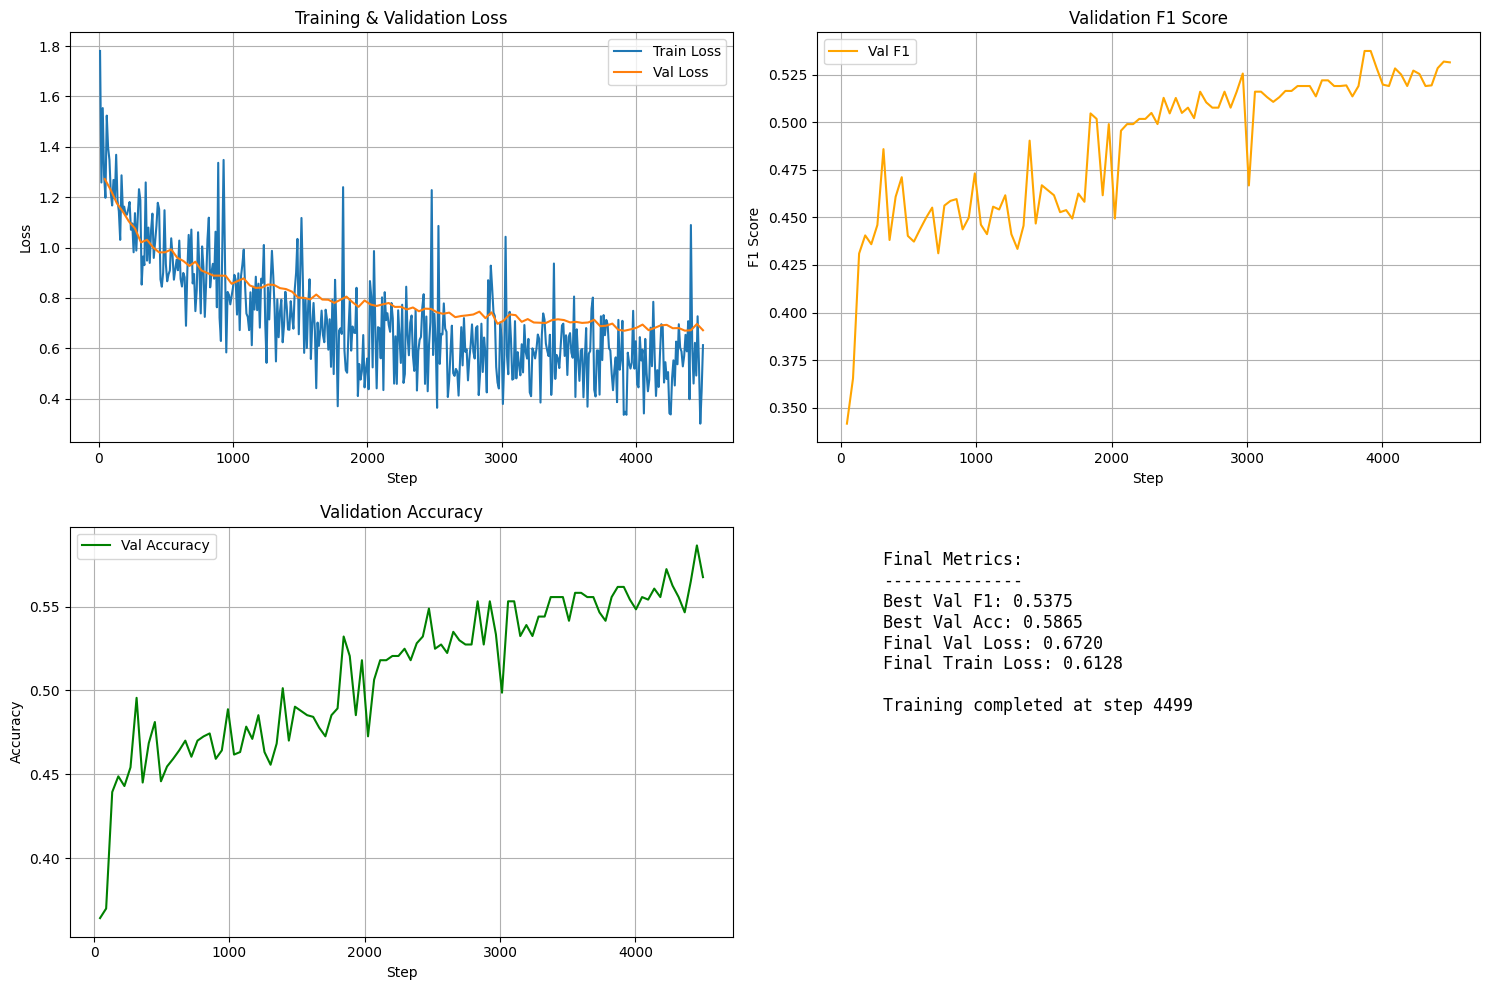


Plot saved to /content/drive/MyDrive/ICPR/training_metrics.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

# Path to your version folder
log_dir = "/content/drive/MyDrive/ICPR/outputs/crop_classification/version_2"

# Load the events
ea = event_accumulator.EventAccumulator(log_dir)
ea.Reload()

# Get available metrics
print("Available metrics:", ea.Tags()['scalars'])

# Extract metrics to dataframes
def get_metric(ea, metric_name):
    events = ea.Scalars(metric_name)
    return pd.DataFrame({
        'step': [e.step for e in events],
        'value': [e.value for e in events]
    })

# Get your metrics
train_loss = get_metric(ea, 'train/loss')
val_loss = get_metric(ea, 'val/loss')
val_f1 = get_metric(ea, 'val/F1_Score')
val_acc = get_metric(ea, 'val/Accuracy')

# ============================================================================
# Plot
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(train_loss['step'], train_loss['value'], label='Train Loss')
axes[0, 0].plot(val_loss['step'], val_loss['value'], label='Val Loss')
axes[0, 0].set_xlabel('Step')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training & Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# F1 Score
axes[0, 1].plot(val_f1['step'], val_f1['value'], label='Val F1', color='orange')
axes[0, 1].set_xlabel('Step')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].set_title('Validation F1 Score')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Accuracy
axes[1, 0].plot(val_acc['step'], val_acc['value'], label='Val Accuracy', color='green')
axes[1, 0].set_xlabel('Step')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Validation Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Summary stats
axes[1, 1].axis('off')
summary_text = f"""
Final Metrics:
--------------
Best Val F1: {val_f1['value'].max():.4f}
Best Val Acc: {val_acc['value'].max():.4f}
Final Val Loss: {val_loss['value'].iloc[-1]:.4f}
Final Train Loss: {train_loss['value'].iloc[-1]:.4f}

Training completed at step {train_loss['step'].iloc[-1]}
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=12, family='monospace')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ICPR/training_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to /content/drive/MyDrive/ICPR/training_metrics.png")

#### Prediction and Submission CV

In [ ]:
# ============================================================================
# Test Set Prediction & CSV Generation
# ============================================================================

# Step 1: Load checkpoint
checkpoint_path = "/content/drive/MyDrive/ICPR/outputs/crop_classification/version_4/checkpoints/best-checkpoint-epoch=93-val_f1=0.00.ckpt"
model = ClassificationTask.load_from_checkpoint(checkpoint_path)

# Step 2: Create datamodule with test set
datamodule_test = ICPRDataModule(
    data_root=test_dir,
    batch_size=BATCH_SIZE,
    num_workers=2,
    means=PRITHVI_MEANS,
    stds=PRITHVI_STDS
)

datamodule_test.setup(stage="predict")

# Step 3: Run predictions
trainer = pl.Trainer(accelerator="auto", devices=1)
predictions = trainer.predict(model, datamodule=datamodule_test)

# Step 4: Process predictions
all_preds = []
all_files = []

for pred_batch, file_batch in predictions:
    all_preds.extend(pred_batch.cpu().numpy())
    all_files.extend(file_batch)

# Step 5: Map to class names
class_names = ['Aphid', 'Blast', 'RPH', 'Rust']
predicted_classes = [class_names[pred] for pred in all_preds]

# Step 6: Create DataFrame and save CSV
submission = pd.DataFrame({
    'Id': all_files,
    'Category': predicted_classes
})

# Preview
print("Submission preview:")
print(submission.head(10))
print(f"\nClass distribution:")


# Save CSV
submission_path = '/content/drive/MyDrive/ICPR/outputs/submission_4.csv'
submission.to_csv(submission_path, index=False)

print(f"\n Submission saved to: {submission_path}")

Found 40 images in /content/drive/MyDrive/ICPR/outputs/preprocessed/test


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch

Found 40 images in /content/drive/MyDrive/ICPR/outputs/preprocessed/test


Output()

Submission preview:
                                 Id Category
0  05835a9764364429b5ac3e11b052649d    Aphid
1  13739e32e7a84f669e6ef1284715e93b    Blast
2  1a419acc1ecc467897d5477a47353fa8      RPH
3  2fb5f497ae1b4b1eb7e8d7ced143aa46     Rust
4  310283f25b5f4b038114acbb6d61a357    Aphid
5  342a74c6432d458d956ba20ad71339c0    Aphid
6  34ff69d337a448d5acf24c06d134c07a    Aphid
7  36eb3780202748baa0164000b4e2e5b3      RPH
8  4da1b698cdad4c8db6c1716a51a56bd4    Blast
9  5bf370118f3043f1bbeafbb91bd78f32      RPH

Class distribution:

 Submission saved to: /content/drive/MyDrive/ICPR/outputs/submission_4.csv
